In [100]:
import copy
import cv2
from PIL import Image
import time

def timeit(func, *args, **kwargs):
    
    def timed(func, args, kwargs):
        t1 = time.time()
        result = func(*args, **kwargs)
        t2 =  time.time()
        print("method: {a}, time : {b: 0.6f} sec".format(a=func.__name__, b=t2-t1))
        return result
    return timed(func, args, kwargs)

In [99]:
url = '/Users/yunsu/Desktop/W2_OCR/W2/2014.png'

In [97]:
# url = '/Users/yunsu/Desktop/W2_OCR/W2/Target_OCR.png'

In [101]:
img_list = pre_process(url=url)

method: check_line_wit, time :  0.077451 sec
method: find_joints, time :  0.126261 sec
method: make_points_list, time :  2.950426 sec
method: align_points, time :  0.000147 sec
method: give_conditions, time :  0.002578 sec
method: classify_points, time :  0.000064 sec
method: cut_points, time :  0.000108 sec
method: fix_st_vertical, time :  0.002874 sec
method: fix_st_horizontal, time :  0.003017 sec
method: fix_st, time :  0.000017 sec
method: make_crack, time :  0.004878 sec
method: pre_process, time :  3.113139 sec


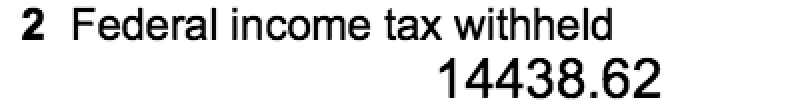

In [94]:
img_list[5]

In [107]:
@timeit
def find_joints(url=None, img=None):
    if url:
        # 이미지를 읽는다.
        src = cv2.imread(url)
        # 이미지를 회색화한다.
        gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    elif img:
        if img.mode != "L":
            gray = img.convert("L")
        else:
            gray = img
    # 이미지 전처리_ 잡티제거 및 색 진하게 
    cleaned_img = cv2.adaptiveThreshold(~gray, 255,
                                        cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY,
                                        11,
                                        -2)
    horizontal = cleaned_img.copy()
    vertical = cleaned_img.copy()

    # v_size와 v_size2는 중요하다. v_size는 전체 이미지 높이의 1/20에 해당되는 길이의 수직선부터 테이블을 구성할 수 있다고 생각하는 것.
    # v_size2는 수평선과 수직선의 교차점을 찾을 때 확실히 해주기 위해 도와주는 추가적인 코드다.
    v_size = vertical.shape[0] // 20
    adjust_value = max(1, vertical.shape[0] // 100)
    vertical_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_size))
    vertical_adjust = cv2.getStructuringElement(cv2.MORPH_RECT,
                                                (1, adjust_value))
    v_final = cv2.erode(vertical, vertical_struct, iterations=1)
    v_final = cv2.dilate(v_final, vertical_struct, iterations=1)
    v_final = cv2.dilate(v_final, vertical_adjust, iterations=1)

    h_size = horizontal.shape[1] // 20
    horizontal_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (h_size, 1))
    horizontal_adjust = cv2.getStructuringElement(cv2.MORPH_RECT,
                                                  (adjust_value, 1))
    h_final = cv2.erode(horizontal, horizontal_struct, iterations=1)
    h_final = cv2.dilate(h_final, horizontal_struct, iterations=1)
    h_final = cv2.dilate(h_final, horizontal_adjust, iterations=1)
    line_wit = check_line_wit(h_final)
    joints = cv2.bitwise_and(v_final, h_final)
    mask = h_final + v_final
    return joints, mask, line_wit, adjust_value, h_final, v_final

@timeit
# 0.06797 sec
def check_line_wit(h_final):
    # linewit은 나중에 이미지 자를 때 중요한 값이다. 선분의 두께에 따라서 이미지에 선분이 잘려 나타날 수 있다.  
    # h_final은 수평선을 이루는 픽셀만 제외하고 모두 0으로 처리되어 있는 벡터
    # 테이블을 이루는 선의 두께중 가장 두꺼운 선의 두께를 찾아주는 함수.
    # 수평선을 이루는 픽섹들 중 값이 200이 넘는 픽셀은 명확도를 위해서 255로 
    h_final[h_final >= 200] = 255
    wit = 0
    wit_list = []
    width = h_final.shape[1]
    height= h_final.shape[0]
    
    # h_final의 모든 값을 다 다니지 않고, 수평길이를 5가지로 나누어 각 점을 지나는 수직선 중 가장 두꺼운 선분의 길이를 찾으려고 작성. 
    # numpy에서 [y_start: y_end, x_start: x_end]은 수직으로 가져올 좌표 시작과 끝값과 수평으로 가져올 좌표 시작과 끝값을 의미한다. 
    # 즉 사각형을 가져온다. 
    for point in list(map(lambda x: x * width//20, range(20))):
        for p in h_final[:, point]:
            if p == 255:
                wit += 1
            else:
                wit_list.append(wit)
                wit = 0
                
    for point in list(map(lambda x: x * height//20, range(20))):
        for p in h_final[:, point]:
            if p == 255:
                wit += 1
            else:
                wit_list.append(wit)
                wit = 0
                
                
    line_wit = max(wit_list)
    return line_wit   

# joints에는 한 리전에도 수 많은 점들이 있는데 한 리전당 하나의 포인트만 남기기 위해서 사용한다. 
# 2번 도는 코드를 한번만 도도록 리펙토링
# 10 sec
@timeit
def make_points_list(line_wit, v_size2, joints):
    re_joints = joints.copy()
    one_line = []
    iran = joints.shape[0]
    jran = joints.shape[1]
    for i in range(iran):
        for j in range(jran):
            # 값이 0이 아닌 리전을 찾으면, 선 두께를 기준으로 모두 0으로 초기화해준다. 
            # 초기화 시킬 기준을 선 두께로 사용해서 주위에 있을 또 다른 테이블을 이루는 리전에 영향을 주지 않게 한다. 
            # 초기화 된 후에는 i,j값을 기준으로 하나의 점의 픽셀값만 255로 바꾸어준다. 
            if re_joints[i][j] != 0:
                re_joints[max(0, i - line_wit * 2): min(i + line_wit * 2, joints.shape[0] - 1),
                max(0, j - line_wit * 2): min(j + line_wit * 2, joints.shape[1] - 1)] = 0
                re_joints[i][j] = 255
                one_line.append((i,j))
    return one_line

#0.0001sec
@timeit
def align_points(one_line, joints):
    points = {}
    tmp = []
    k = 0
    fst = one_line[0]
    for pos in one_line:
        plow = fst[0]
        # allow는 경험적 데이터로, 테이블이 비틀어졌을 때를 대비해 allow만큼 비틀린 테이블까지는 인식하겠다는 말이다.
        allow = int(joints.shape[0] * 0.03)
        rng = range(max(0, plow - allow), min(joints.shape[0] - 1, plow + allow))
        if pos[0] in rng:
            tmp.append(pos)
        else:
            tmp = sorted(tmp, key=lambda x: x[1])
            k += 1
            points['line' + str(k)] = tmp
            tmp = []
            fst = pos
            tmp.append(pos)
    k += 1
    points['line' + str(k)] = tmp
    return points

@timeit
def make_box(points, joints, v_size2, line_wit):
    # 점 주위에 박스처리 해주는 기능
    depth = max(3, v_size2 + line_wit * 2)
    box = np.zeros_like(joints)
    for i in range(1, len(points) + 1):
        line = points['line' + str(i)]
        for idx, p in enumerate(line):
            box[max(0, p[0] - depth), max(0, p[1] - depth): min(joints.shape[1] - 1, p[1] + depth)] = 255
            box[max(0, p[0] - depth): min(joints.shape[0] - 1, p[0] + depth), max(0, p[1] - depth)] = 255
            box[min(joints.shape[0] - 1, p[0] + depth),
            max(0, p[1] - depth): min(joints.shape[1] - 1, p[1] + depth)] = 255
            box[min(joints.shape[0] - 1, p[0] - depth): min(joints.shape[0] - 1, p[0] + depth),
            min(joints.shape[1] - 1, p[1] + depth)] = 255
    return box

@timeit
def show_box(box, mask):
    boxed = box + mask
    cv2.imshow('boxed', boxed)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    return None

@timeit
def give_conditions(points, mask, v_size2, line_wit):
    # 좌표에 컨디션을 부과해주는 함수
    mask[mask > 240] = 255
    depth = max(3, v_size2 + line_wit * 2)
    c_points = copy.deepcopy(points)
    for i in range(1, len(c_points) + 1):
        line = c_points['line' + str(i)]
        for idx, p in enumerate(line):
            tmp = ''
            c1 = 255 in mask[max(0, p[0] - depth), max(0, p[1] - depth): min(mask.shape[1] - 1, p[1] + depth)]
            c2 = 255 in mask[max(0, p[0] - depth): min(mask.shape[0] - 1, p[0] + depth), max(0, p[1] - depth)]
            c3 = 255 in mask[min(mask.shape[0] - 1, p[0] + depth),
                        max(0, p[1] - depth): min(mask.shape[1] - 1, p[1] + depth)]
            c4 = 255 in mask[min(mask.shape[0] - 1, p[0] - depth): min(mask.shape[0] - 1, p[0] + depth),
                        min(mask.shape[1] - 1, p[1] + depth)]
            if c1:
                tmp += 'c1'
            if c2:
                tmp += 'c2'
            if c3:
                tmp += 'c3'
            if c4:
                tmp += 'c4'
            line[idx] = (p, tmp)
    return c_points

@timeit
def classify_points(c_points, joints, v_size2, line_wit, mask, points):
    # 좌표를 각각 시작점, 보조점, 끝점으로 분류해주는 기능.
    for depth_bound in range(3, 6):
        allow = int(joints.shape[1] * 0.02)
        is_st = []
        is_end = []
        is_right = []
        is_bot = []
        for i in range(1, len(c_points) + 1):
            line = c_points['line' + str(i)]
            for idx, p in enumerate(line):
                if 'c3c4' in p[1]:
                    is_st.append(p[0])
                if 'c1c2' in p[1]:
                    is_end.append(p[0])
                if 'c2c3' in p[1]:
                    is_right.append(p[0])
                if 'c1' in p[1] and 'c4' in p[1]:
                    is_bot.append(p[0])
        if len(is_st) == len(is_right) == len(is_bot) == len(is_end):
            break
        else:
            print("시작점과 다른 점들의 수가 맞지 않습니다.")
            print("depth를 더 늘려 수정진행합니다.")
            # 점 주위에 박스처리 해주는 기능
            up_line_wit = line_wit * depth_bound
            box = make_box(points, joints, v_size2, up_line_wit)
            show_box(box, mask)

            # 좌표에 컨디션을 부과해주는 함수
            c_points = give_conditions(points, mask, v_size2, up_line_wit)
    return is_st, is_bot, is_end, is_right

    # 자를 좌표를 정해주는 기능

@timeit
def cut_points(joints, is_st, is_bot, is_end, is_right):
    st = []
    end = []
    allow = int(joints.shape[1] * 0.02)
    # 스타트 다음에 나오는 right 는 무조건 직전 스타트와 사각형을 이룬다.
    for idx, p in enumerate(is_st):
        st.append(p)
        rgt = is_right[idx]
        for thing in is_bot:
            if thing[1] in range(p[1] - allow, p[1] + allow):
                bot = thing
                is_bot.remove(thing)
                break
        for thing in is_end:
            if thing[0] in range(bot[0] - allow, bot[0] + allow) and thing[1] in range(rgt[1] - allow, rgt[1] + allow):
                end.append(thing)
                is_end.remove(thing)
                break
    return st, end

@timeit
def fix_st_horizontal(v_final, st):
    allow = 3
    certain = 50
    assume_wit = 15
    v_final[v_final > 240] = 255
    fix_st_1 = []
    for start in st:
        for move in range(assume_wit):
            if 255 in v_final[max(0, start[0] + certain - allow): min(v_final.shape[0] - 1, start[0] + certain + allow),
                      start[1] + assume_wit - move]:
                fix_st_1.append(assume_wit - move + 1)
                break
            if move == assume_wit - 1:
                fix_st_1.append(0)
    return fix_st_1

@timeit
# 각 테이블 윤곽선 두께가 다를 수 있기때문에 두께를 고려해서 시작점의 vertical 좌표에 더하거나 뺄 값을 계산한다.
# 인자는 v_final이 아니라 h_final이 들어간다는 점에 유의해야한다.
def fix_st_vertical(h_final, st):
    allow = 3
    certain = 20
    assume_wit = 15
    h_final[h_final > 240] = 255
    fix_st_0 = []
    for start in st:
        for move in range(1, assume_wit):
            # 시작점이 좌상단에 있기 때문에 실제 테이블의 굵기가 아닌 옆 테이블의 굵기를 측정할 수 있다. width에만 해당된다. 따라서 certain 값을 더해
            # 자신 테이블의 윗 수평선 굵기를 잰다.
            # start[0] 좌표에서 assume_wit만큼 내려오면 흰 여백에 위치한다. 이 곳에서 위쪽으로 조금씩(move)하면서 테이블 검은 선과 만날 때
            # start[0] 에서부터의 검은선까지의 거리를 계산한다. 이렇게하지 않으면 테이블 선 내부에 흰 공간이 있는 경우 오류를 내게 되서 이런 코드를
            # 짜게 되었다.
            # certain은 오른쪽으로 이동하는 값인데, 오른쪽으로 이동하지 않으면 옆에 테이블 윤곽선의 두께에 영향을 받기 때문에, 영향을 최소화하기 위해
            # 확실히 옆테이블과 떨어진 위치에서 떨어져(certain) 계산한다.
            # allow는 예측하지못한 상황에서 대비하기 위해 작성했는데, 상황에 따라 없어야 하는 코드가 될 수 있다.!
            if 255 in h_final[start[0] + assume_wit - move,
                      max(0, start[1] + certain - allow): min(h_final.shape[1] - 1, start[1] + certain + allow)]:
                fix_st_0.append(assume_wit - move + 1)
                break
            if move == assume_wit - 1:
                fix_st_0.append(0)
    return fix_st_0

@timeit
def fix_st(st, fix_st_1, fix_st_0):
    for idx, add in enumerate(zip(fix_st_0, fix_st_1)):
        tmp = st[idx][0] + add[0], st[idx][1] + add[1]
        st[idx] = tmp
    return st

@timeit
def make_crack(ful_img, st, end):
    img_list = []

    for i in range(len(st)):
        # +1을 해주는 이유, img는 시작값이 0이아닌 1이기 때문에 배열의 모양과 맞추려면 +1이 맞음.
        tmp = ful_img.crop((st[i][1] + 1, st[i][0] + 1, end[i][1] - 1, end[i][0] - 1))
        # 글자가 작은 경우 잘못 읽는 경우가 생겨, 시간 비용이 들더라도 정확도를 올려주기 위해 이미지 사이즈를 2배로 늘린다.
        size = (tmp.size[0] * 2, tmp.size[1] * 2)
        tmp = tmp.resize(size)
        img_list.append(tmp)
    return img_list

@timeit
#13번 박스를 위한 코드
def align_small_box_points(one_line, joints):
    points = {}
    tmp = []
    k = 0
    fst = one_line[0]
    for pos in one_line:
        plow = fst[0]
        # allow는 경험적 데이터로, 테이블이 비틀어졌을 때를 대비해 allow만큼 비틀린 테이블까지는 인식하겠다는 말이다.
        # 전체 테이블의 크기가 작고, 그안에 박스 테이블이 상대적으로 클 경우에 경험적 데이터로 10픽셀을 준다.
        allow = 10
        rng = range(max(0, plow - allow), min(joints.shape[0] - 1, plow + allow))
        if pos[0] in rng:
            tmp.append(pos)
        else:
            tmp = sorted(tmp, key=lambda x: x[1])
            k += 1
            points['line' + str(k)] = tmp
            tmp = []
            fst = pos
            tmp.append(pos)
    k += 1
    points['line' + str(k)] = tmp
    return points

@timeit
def check_max_line_wit(h_final):
    h_final[h_final >= 200] = 255
    wit = 0
    wit_candidate = []
    line_wit_list = []
    for i in range(h_final.shape[1]):
        for p in h_final[:, i]:
            if p == 255:
                wit += 1
            else:
                wit_candidate.append(wit)
                wit = 0
        line_wit_list.append(max(wit_candidate))
    line_wit = max(line_wit_list)
    return line_wit

@timeit
def find_box_joints(img):
    #이미지를 읽는다.
    src = np.array(img)
    if img.mode != 'L':
        gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    else:
        gray = src
    # 이미지 전처리_ 잡티제거
    bw = cv2.adaptiveThreshold(~gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -5)
    horizontal = bw.copy()
    vertical = bw.copy()
    #v_size와 adjust_value는 중요하다. v_size는 전체 이미지 높이의 1/20에 해당되는 길이의 수직선부터 테이블을 구성할 수 있다고 생각하는 것.
    #adjust_value는 수평선과 수직선의 교차점을 찾을 때 확실히 해주기 위해 도와주는 추가적인 코드다.
    v_size = vertical.shape[0]//3
    adjust_value = max(1, vertical.shape[0]//100)
    vertical_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_size))
    vertical_adjust = cv2.getStructuringElement(cv2.MORPH_RECT, (1, adjust_value))
    v_final = cv2.erode(vertical, vertical_struct, iterations=1)
    v_final = cv2.dilate(v_final, vertical_struct, iterations=1)
    v_final = cv2.dilate(v_final, vertical_adjust, iterations=1)
    h_size = horizontal.shape[1]//30
    h_struct = cv2.getStructuringElement(cv2.MORPH_RECT,(h_size,1))
    h_struct2 = cv2.getStructuringElement(cv2.MORPH_RECT,(adjust_value,1))
    h_final = cv2.erode(horizontal, h_struct, iterations = 1)
    h_final = cv2.dilate(h_final, h_struct, iterations = 1)
    h_final = cv2.dilate(h_final, h_struct2, iterations = 1)
    line_wit = check_max_line_wit(h_final)
    joints = cv2.bitwise_and(v_final, h_final)
    mask = h_final + v_final
    return joints, mask, line_wit, adjust_value, h_final, v_final


@timeit
def pre_process(url=None, img=None, show=False):
    if url:
        src = cv2.imread(url)
        gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        img = Image.fromarray(gray)
        if src.all():
            print("None Type Error : 이미지를 받아오지 못했습니다.")
    if img:
        if img.mode != "L":
            img = img.convert("L")
            
    joints, mask, line_wit, v_size2, h_final, v_final = find_joints(url=url, img=img)
    one_line = make_points_list(
        joints=joints, line_wit=line_wit, v_size2=v_size2
    )
    points = align_points(one_line=one_line, joints=joints)
    if show == True:
        box = make_box(points, joints, v_size2, line_wit)
        show_box(box=box, mask=mask)
    c_points = give_conditions(
        points=points, mask=mask, v_size2=v_size2, line_wit=line_wit
    )
    is_st, is_bot, is_end, is_right = classify_points(
        c_points=c_points, joints=joints, v_size2=v_size2, line_wit=line_wit,
        mask=mask, points=points)
    st, end = cut_points(joints=joints, is_st=is_st, is_bot=is_bot,
                         is_end=is_end, is_right=is_right)
    fix_st_0 = fix_st_vertical(h_final, st=st)
    fix_st_1 = fix_st_horizontal(v_final, st=st)
    st = fix_st(st, fix_st_0=fix_st_0, fix_st_1=fix_st_1)
    img_list = make_crack(ful_img=img, st=st, end=end)
    return img_list


In [106]:
def timeit(func):
    def timed(*args, **kwargs):
        t1 = time.time()
        result = func(*args, **kwargs)
        t2 =  time.time()
        print("method: {a}, time : {b: 0.6f} sec".format(a=func.__name__, b=t2-t1))
        return result
    return timed

In [83]:
@timeit
def test():
    for i in range(1000):
        if i == 1:
            print("1")

In [84]:
test()

1
method: test, time :  0.000251 sec
